# Gesture Recognition
In this group project, you are going to build a 3D Conv model that will be able to predict the 5 gestures correctly. Please import the following libraries to get started.

In [ ]:
!gdown --id 1s2yQsQODr6R6MkS08hvzRMpUohej6u3D

In [ ]:
!unzip ./Project_data.zip

In [106]:
!rm -rf /kaggle/working/model_init_2024-03-0117_58_00.545860

In [1]:
import numpy as np
import os
from imageio import imread
import datetime
import os

We set the random seed so that the results don't vary drastically.

In [2]:
np.random.seed(30)
import random as rn
rn.seed(30)
from keras import backend as K
import tensorflow as tf
tf.random.set_seed(30)
import cv2
import warnings
warnings.filterwarnings("ignore", )

2024-03-02 08:00:13.240071: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-02 08:00:13.240206: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-02 08:00:13.394568: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

In [3]:
train_doc = np.random.permutation(open('./Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('./Project_data/val.csv').readlines())
batch_size = 64

## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In [4]:
image_count = 16 # number of images to be used for each video
image_height = 160
image_width = 160
num_channels = 3
num_classes = 5 # number of classes
input_shape = (image_count, image_width, image_height, num_channels)

curr_dt_time = datetime.datetime.now()
train_path = './Project_data/train'
val_path = './Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 50
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 50


In [5]:
def generator(source_path, folder_list, batch_size):
#     print( 'Source path = ', source_path, '; batch size =', batch_size)
    img_idx = [x for x in range(0, image_count)]
    while True:
        t = np.random.permutation(folder_list)
        num_batches = len(t)//batch_size    # calculate the number of batches
        for batch in range(num_batches): # we iterate over the number of batches
            batch_data = np.zeros((batch_size, image_count, image_width, image_height, num_channels)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size, num_classes)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch * batch_size)].split(';')[0]) # read all the images in the folder
                for idx, item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch * batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)

                    #crop the images and resize them. Note that the images are of 2 different shape
                    #and the conv3D will throw error if the inputs in a batch have different shapes

                    resized_img = cv2.resize(image, (image_width, image_height))
                    resized_img = resized_img/255 #Normalize data

                    batch_data[folder, idx,:,:,0] = (resized_img[:,:,0])    #normalise and feed in the image
                    batch_data[folder, idx,:,:,1] = (resized_img[:,:,1])    #normalise and feed in the image
                    batch_data[folder, idx,:,:,2] = (resized_img[:,:,2])    #normalise and feed in the image

                batch_labels[folder, int(t[folder + (batch * batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do


        # write the code for the remaining data points which are left after full batches
        if (len(folder_list) != batch_size * num_batches):
#             print("Batch: ", num_batches + 1, "Index:", batch_size)
            batch_size = len(folder_list) - (batch_size * num_batches)
            batch_data = np.zeros((batch_size, image_count, image_width, image_height, num_channels)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size, num_classes)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch * batch_size)].split(';')[0]) # read all the images in the folder
                for idx, item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch * batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)

                    #crop the images and resize them. Note that the images are of 2 different shape
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    resized_img = cv2.resize(image, (image_width, image_height))
                    resized_img = resized_img/255 #Normalize data

                    batch_data[folder, idx,:,:,0] = (resized_img[:,:,0])
                    batch_data[folder, idx,:,:,1] = (resized_img[:,:,1])
                    batch_data[folder, idx,:,:,2] = (resized_img[:,:,2])

                batch_labels[folder, int(t[folder + (batch * batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels


Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

## Model
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

In [6]:
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation, Dropout, GlobalAveragePooling3D, GRU, GlobalAveragePooling2D, LSTM, MaxPool2D, ConvLSTM2D, GlobalAveragePooling1D
from keras.layers import Conv3D, MaxPooling3D,Conv2D, MaxPooling2D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers
from keras.applications import MobileNet

Now that you have written the model, the next step is to `compile` the model. When you print the `summary` of the model, you'll see the total number of parameters you have to train.

## Conv3D

In [18]:
model = Sequential()
model.add(Conv3D(16, (3, 3, 3), padding='same',
          input_shape=input_shape))
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Conv3D(32, (2, 2, 2), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Conv3D(64, (2, 2, 2), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Conv3D(128, (2, 2, 2), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Flatten())
model.add(Dense(128,activation='relu'))
model.add(Dense(64,activation='relu'))

model.add(Dense(num_classes,activation='softmax'))

In [19]:
optimiser = optimizers.Adam()    #write your optimizer
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_4 (Conv3D)           (None, 16, 160, 160, 16   1312      
                             )                                   
                                                                 
 activation_4 (Activation)   (None, 16, 160, 160, 16   0         
                             )                                   
                                                                 
 max_pooling3d_4 (MaxPoolin  (None, 8, 80, 80, 16)     0         
 g3D)                                                            
                                                                 
 conv3d_5 (Conv3D)           (None, 8, 80, 80, 32)     4128      
                                                                 
 activation_5 (Activation)   (None, 8, 80, 80, 32)     0         
                                                      

Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.

In [12]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [13]:
model_name = 'model_init' + '_' + str(datetime.datetime.now()).replace(' ','').replace(':','_') + '/'

if not os.path.exists(model_name):
    os.mkdir(model_name)

filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, verbose=1, mode='auto')    # write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

The `steps_per_epoch` and `validation_steps` are used by `fit_generator` to decide the number of next() calls it need to make.

In [14]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

In [22]:
history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
                    callbacks=callbacks_list, validation_data=val_generator,
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Epoch 1/50


I0000 00:00:1708797759.580752     103 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


11/11 [==============================] - ETA: 0s - loss: 1.6142 - categorical_accuracy: 0.1916
Epoch 1: saving model to model_init_2024-02-2418_01_39.718068/model-00001-1.61423-0.19155-1.57581-0.23000.h5
11/11 [==============================] - 59s 5s/step - loss: 1.6142 - categorical_accuracy: 0.1916 - val_loss: 1.5758 - val_categorical_accuracy: 0.2300 - lr: 0.0010
Epoch 2/50
11/11 [==============================] - ETA: 0s - loss: 1.5466 - categorical_accuracy: 0.2885
Epoch 2: saving model to model_init_2024-02-2418_01_39.718068/model-00002-1.54660-0.28854-1.44808-0.26562.h5
11/11 [==============================] - 23s 2s/step - loss: 1.5466 - categorical_accuracy: 0.2885 - val_loss: 1.4481 - val_categorical_accuracy: 0.2656 - lr: 0.0010
Epoch 3/50
11/11 [==============================] - ETA: 0s - loss: 1.4239 - categorical_accuracy: 0.3320
Epoch 3: saving model to model_init_2024-02-2418_01_39.718068/model-00003-1.42394-0.33202-1.28273-0.41071.h5
11/11 [===========================

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline

<Figure size 2000x1500 with 0 Axes>

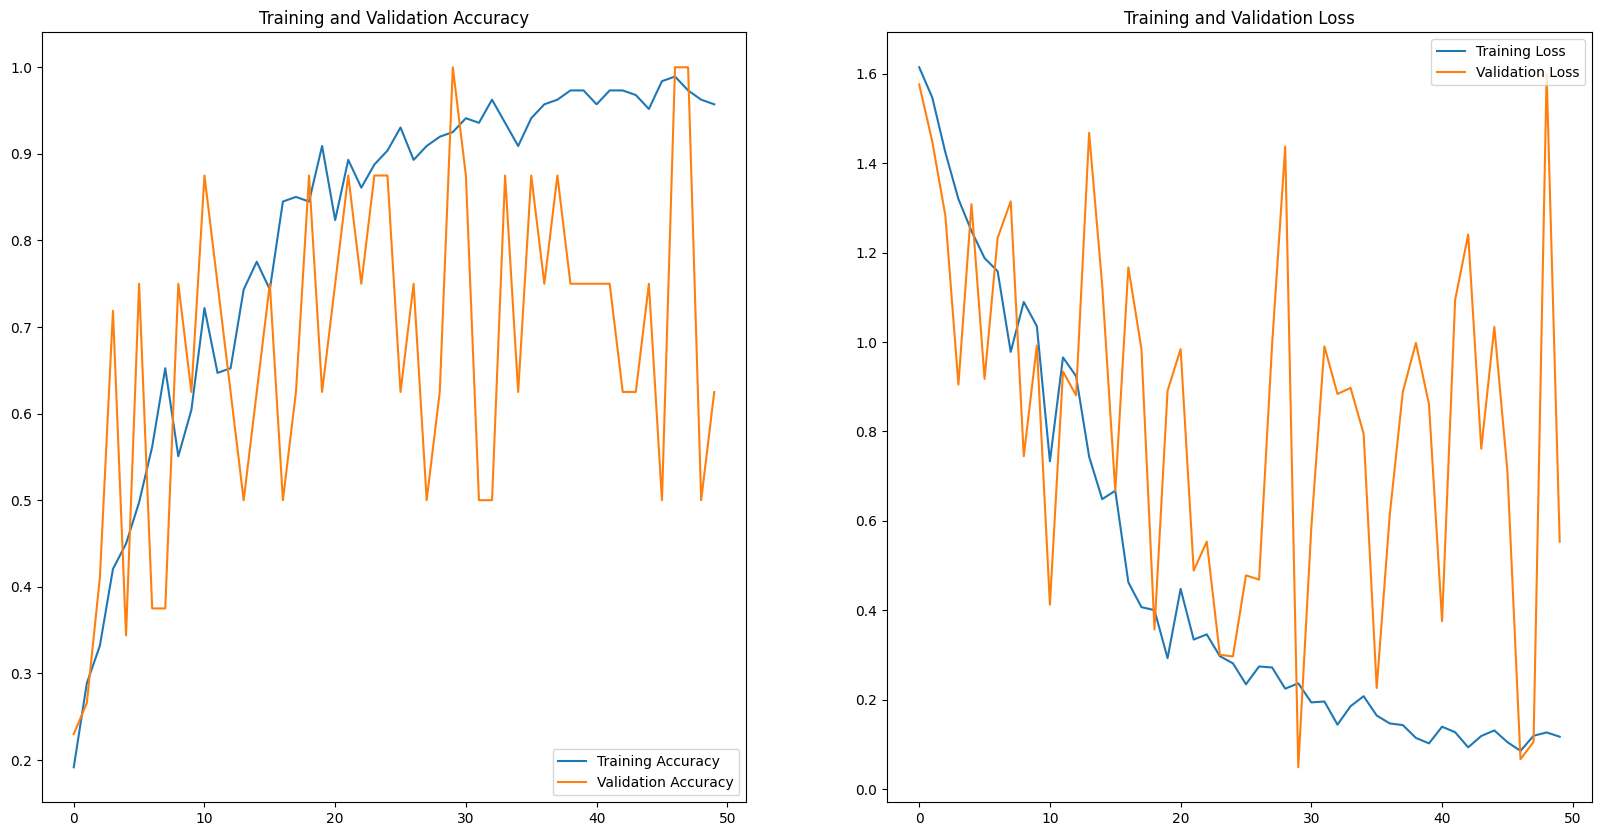

In [24]:
plt.figure(figsize = (20, 15))

acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(num_epochs)

plt.figure(figsize=(20, 10))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [37]:
from keras.models import load_model

# load model at epoch 35
model = load_model('/kaggle/working/model_init_2024-02-2418_01_39.718068/model-00047-0.08564-0.98930-0.06705-1.00000.h5')

In [ ]:
# Evaluate on Validation data
scores = model.evaluate(val_generator, verbose=1, steps=validation_steps*10, workers=1, use_multiprocessing=False)
print("%s%s: %.2f%%" % ("evaluate ",model.metrics_names[1], scores[1]*100))

20/20 [==============================] - 6s 280ms/step - loss: 0.6002 - categorical_accuracy: 0.8000


## Conv2D + GRU

In [8]:
model = Sequential()
model.add(TimeDistributed(
    Conv2D(32, (3,3), activation='relu'), input_shape=input_shape)
)
model.add(TimeDistributed(
    MaxPooling2D((2,2)))
)
model.add(BatchNormalization())

model.add(TimeDistributed(
    Conv2D(64, (3,3), activation='relu'))
)
model.add(TimeDistributed(
    MaxPooling2D((2,2)))
)
model.add(BatchNormalization())

model.add(TimeDistributed(GlobalAveragePooling2D()))
model.add(TimeDistributed(Dense(64, activation='relu')))
model.add(BatchNormalization())

model.add(GRU(128))
model.add(BatchNormalization())
model.add(Dense(5, activation='softmax'))

In [9]:
optimiser = optimizers.Adam() #write your optimizer
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDist  (None, 16, 158, 158, 32   896       
 ributed)                    )                                   
                                                                 
 time_distributed_1 (TimeDi  (None, 16, 79, 79, 32)    0         
 stributed)                                                      
                                                                 
 batch_normalization (Batch  (None, 16, 79, 79, 32)    128       
 Normalization)                                                  
                                                                 
 time_distributed_2 (TimeDi  (None, 16, 77, 77, 64)    18496     
 stributed)                                                      
                                                                 
 time_distributed_3 (TimeDi  (None, 16, 38, 38, 64)    0

In [10]:
model_name = 'model_init' + '_' + str(datetime.datetime.now()).replace(' ','').replace(':','_') + '/'

if not os.path.exists(model_name):
    os.mkdir(model_name)

filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, verbose=1, mode='auto')    # write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

In [15]:
history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
                    callbacks=callbacks_list, validation_data=val_generator,
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Epoch 1/50


I0000 00:00:1709366474.931890     103 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


11/11 [==============================] - ETA: 0s - loss: 1.4002 - categorical_accuracy: 0.4646
Epoch 1: saving model to model_init_2024-03-0208_00_35.882169/model-00001-1.40021-0.46456-1.60773-0.20000.h5
11/11 [==============================] - 68s 5s/step - loss: 1.4002 - categorical_accuracy: 0.4646 - val_loss: 1.6077 - val_categorical_accuracy: 0.2000 - lr: 0.0010
Epoch 2/50
11/11 [==============================] - ETA: 0s - loss: 1.2079 - categorical_accuracy: 0.4980
Epoch 2: saving model to model_init_2024-03-0208_00_35.882169/model-00002-1.20789-0.49802-1.60603-0.14062.h5
11/11 [==============================] - 22s 2s/step - loss: 1.2079 - categorical_accuracy: 0.4980 - val_loss: 1.6060 - val_categorical_accuracy: 0.1406 - lr: 0.0010
Epoch 3/50
11/11 [==============================] - ETA: 0s - loss: 1.0902 - categorical_accuracy: 0.5850
Epoch 3: saving model to model_init_2024-03-0208_00_35.882169/model-00003-1.09020-0.58498-1.57648-0.25000.h5
11/11 [===========================

<Figure size 2000x1500 with 0 Axes>

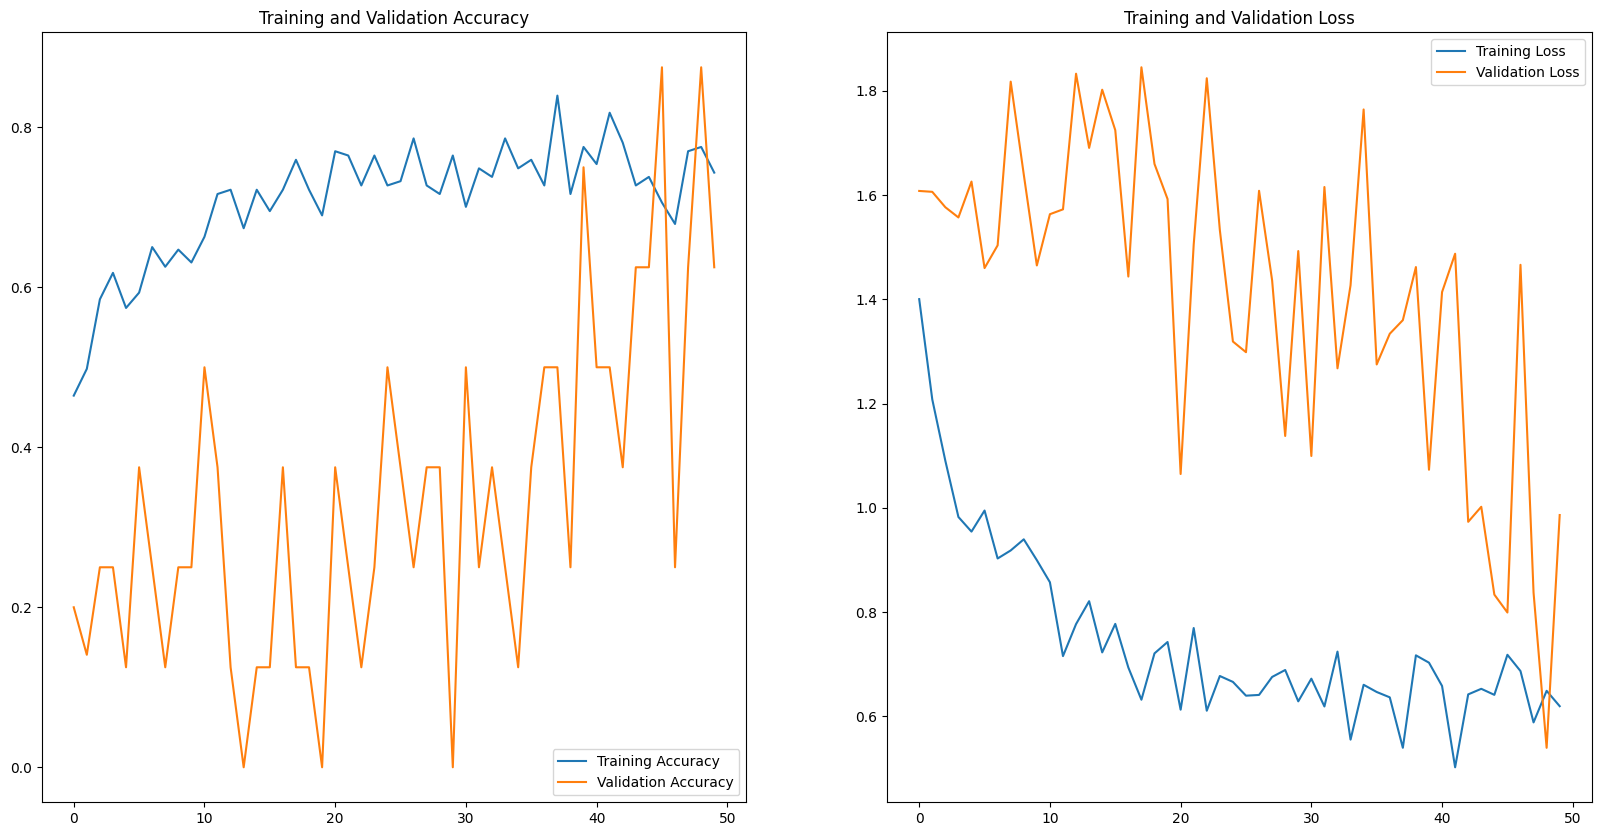

In [16]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize = (20, 15))

acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(num_epochs)

plt.figure(figsize=(20, 10))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [17]:
from keras.models import load_model

# load model
model = load_model('/kaggle/working/model_init_2024-03-0208_00_35.882169/model-00049-0.64902-0.77540-0.53973-0.87500.h5')
# summarize model.

In [24]:
# Evaluate on Validation data
scores = model.evaluate(val_generator, verbose=1, steps=validation_steps*10, max_queue_size=3000, workers=1, use_multiprocessing=False)
print("%s%s: %.2f%%" % ("evaluate ",model.metrics_names[1], scores[1]*100))

20/20 [==============================] - 5s 276ms/step - loss: 1.0414 - categorical_accuracy: 0.5750
evaluate categorical_accuracy: 57.50%


## TimeDistributed + ConvLSTM2D

In [24]:
model = Sequential()
model.add(TimeDistributed(
    Conv2D(8, (3,3), activation='relu'), input_shape=input_shape)
)
model.add(BatchNormalization())
model.add(TimeDistributed(
    Conv2D(16, (3,3), activation='relu'))
)
model.add(BatchNormalization())
model.add(
    ConvLSTM2D(8, kernel_size = 3, return_sequences=False)
)
model.add(BatchNormalization())
model.add(TimeDistributed(
    Dense(64, activation='relu'))
)
model.add(BatchNormalization())
model.add(GlobalAveragePooling2D())
model.add(Dense(64, activation='relu'))
model.add(Dense(5, activation='softmax'))

In [25]:
optimiser = optimizers.Adam() #write your optimizer
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(model.summary())

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_15 (TimeD  (None, 16, 158, 158, 8)   224       
 istributed)                                                     
                                                                 
 batch_normalization_12 (Ba  (None, 16, 158, 158, 8)   32        
 tchNormalization)                                               
                                                                 
 time_distributed_16 (TimeD  (None, 16, 156, 156, 16   1168      
 istributed)                 )                                   
                                                                 
 batch_normalization_13 (Ba  (None, 16, 156, 156, 16   64        
 tchNormalization)           )                                   
                                                                 
 conv_lstm2d_1 (ConvLSTM2D)  (None, 154, 154, 8)      

In [23]:
model_name = 'model_init' + '_' + str(datetime.datetime.now()).replace(' ','').replace(':','_') + '/'

if not os.path.exists(model_name):
    os.mkdir(model_name)

filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, verbose=1, mode='auto')    # write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

In [26]:
history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
                    callbacks=callbacks_list, validation_data=val_generator,
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Epoch 1/50
11/11 [==============================] - ETA: 0s - loss: 1.5859 - categorical_accuracy: 0.2781
Epoch 1: saving model to model_init_2024-02-2506_30_50.556699/model-00001-1.58588-0.27807-1.59752-0.00000.h5
11/11 [==============================] - 16s 1s/step - loss: 1.5859 - categorical_accuracy: 0.2781 - val_loss: 1.5975 - val_categorical_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 2/50
11/11 [==============================] - ETA: 0s - loss: 1.5122 - categorical_accuracy: 0.4118
Epoch 2: saving model to model_init_2024-02-2506_30_50.556699/model-00002-1.51218-0.41176-1.60282-0.25000.h5
11/11 [==============================] - 12s 1s/step - loss: 1.5122 - categorical_accuracy: 0.4118 - val_loss: 1.6028 - val_categorical_accuracy: 0.2500 - lr: 0.0010
Epoch 3/50
11/11 [==============================] - ETA: 0s - loss: 1.4325 - categorical_accuracy: 0.4225
Epoch 3: saving model to model_init_2024-02-2506_30_50.556699/model-00003-1.43254-0.42246-1.60112-0.25000.h5
11/11 [============

<Figure size 2000x1500 with 0 Axes>

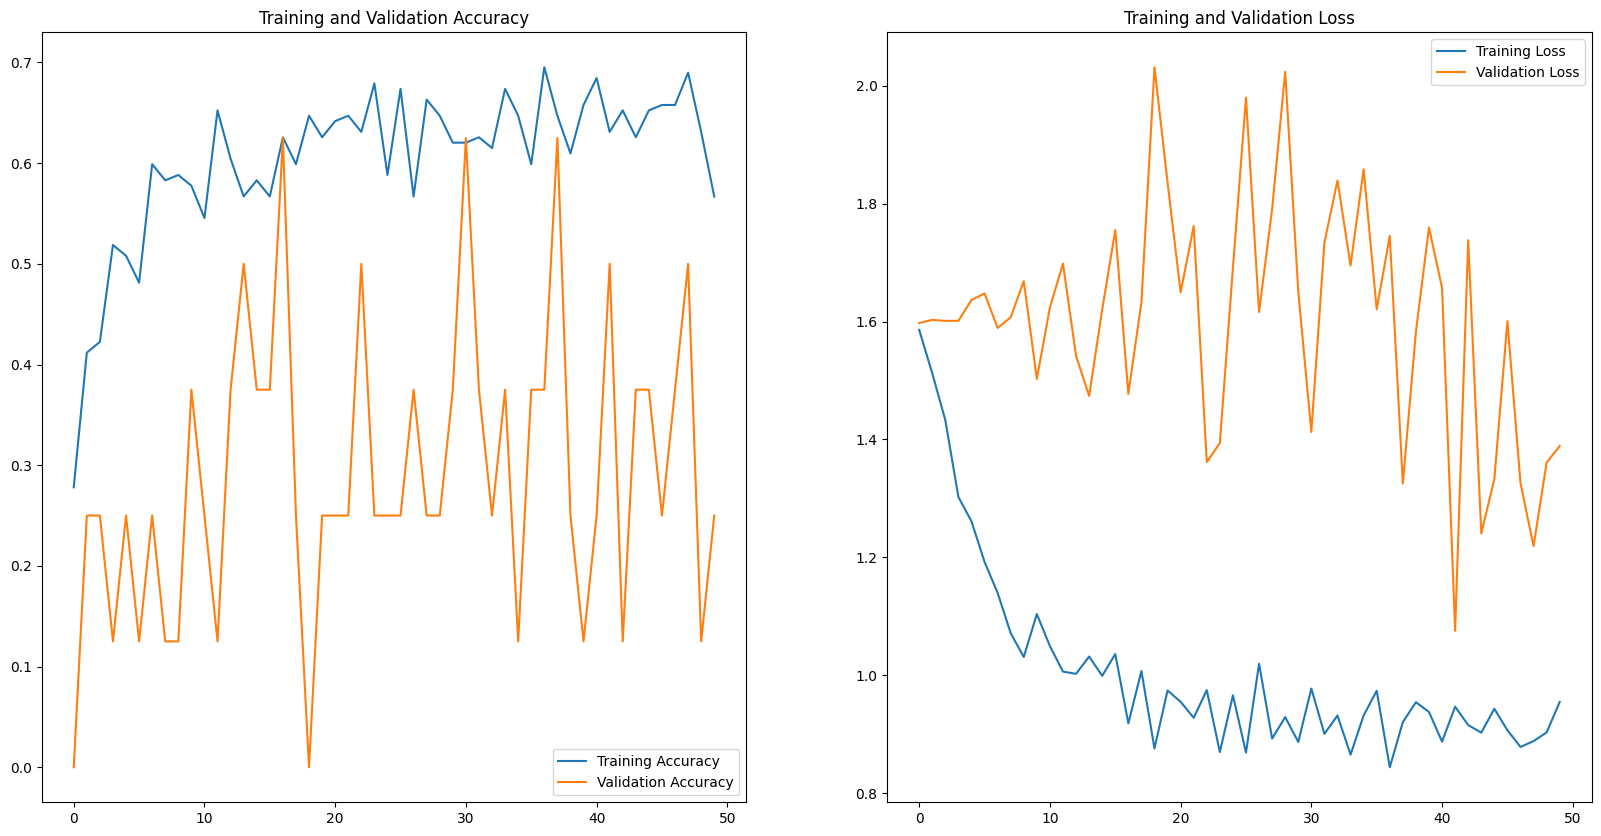

In [27]:
plt.figure(figsize = (20, 15))

acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(num_epochs)

plt.figure(figsize=(20, 10))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [28]:
from keras.models import load_model

# load model
model = load_model('/kaggle/working/model_init_2024-02-2506_30_50.556699/model-00017-0.91871-0.62567-1.47732-0.62500.h5')

In [35]:
# Evaluate on Validation data
scores = model.evaluate(val_generator, verbose=1, steps=validation_steps*10, max_queue_size=3000, workers=1, use_multiprocessing=False)
print("%s%s: %.2f%%" % ("evaluate ",model.metrics_names[1], scores[1]*100))

20/20 [==============================] - 5s 252ms/step - loss: 1.5926 - categorical_accuracy: 0.2875
evaluate categorical_accuracy: 28.75%


## Transfer Learning

In [107]:
from keras.applications import ResNet152V2
# EfficientNetB7 with rnn gru units
model = Sequential()
model.add(TimeDistributed(ResNet152V2(weights='imagenet', include_top=False),input_shape=input_shape, name='ResNet152V2', trainable=False))
model.add(TimeDistributed(GlobalAveragePooling2D()))
model.add(TimeDistributed(Dense(256, activation='relu')))
model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(GRU(256, return_sequences=True))
model.add(BatchNormalization())
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))

In [108]:
optimiser = optimizers.Adam() #write your optimizer
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 ResNet152V2 (TimeDistribut  (None, 16, 5, 5, 2048)    58331648  
 ed)                                                             
                                                                 
 time_distributed_16 (TimeD  (None, 16, 2048)          0         
 istributed)                                                     
                                                                 
 time_distributed_17 (TimeD  (None, 16, 256)           524544    
 istributed)                                                     
                                                                 
 dense_30 (Dense)            (None, 16, 256)           65792     
                                                                 
 batch_normalization_16 (Ba  (None, 16, 256)           1024      
 tchNormalization)                                    

In [109]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [110]:
model_name = 'model_init' + '_' + str(datetime.datetime.now()).replace(' ','').replace(':','_') + '/'

if not os.path.exists(model_name):
    os.mkdir(model_name)

filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, verbose=1, mode='auto')    # write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

The `steps_per_epoch` and `validation_steps` are used by `fit_generator` to decide the number of next() calls it need to make.

In [111]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [112]:
history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=20, verbose=1,
                    callbacks=callbacks_list, validation_data=val_generator,
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Epoch 1/20
11/11 [==============================] - ETA: 0s - loss: 1.6037 - categorical_accuracy: 0.4540
Epoch 1: saving model to model_init_2024-03-0118_07_56.393088/model-00001-1.60368-0.45400-1.30342-0.40000.h5
11/11 [==============================] - 77s 6s/step - loss: 1.6037 - categorical_accuracy: 0.4540 - val_loss: 1.3034 - val_categorical_accuracy: 0.4000 - lr: 0.0010
Epoch 2/20
11/11 [==============================] - ETA: 0s - loss: 0.5911 - categorical_accuracy: 0.8182
Epoch 2: saving model to model_init_2024-03-0118_07_56.393088/model-00002-0.59106-0.81818-2.27438-0.37500.h5
11/11 [==============================] - 25s 2s/step - loss: 0.5911 - categorical_accuracy: 0.8182 - val_loss: 2.2744 - val_categorical_accuracy: 0.3750 - lr: 0.0010
Epoch 3/20
11/11 [==============================] - ETA: 0s - loss: 0.8923 - categorical_accuracy: 0.7510
Epoch 3: saving model to model_init_2024-03-0118_07_56.393088/model-00003-0.89227-0.75099-1.61360-0.37500.h5
11/11 [================

<Figure size 2000x1500 with 0 Axes>

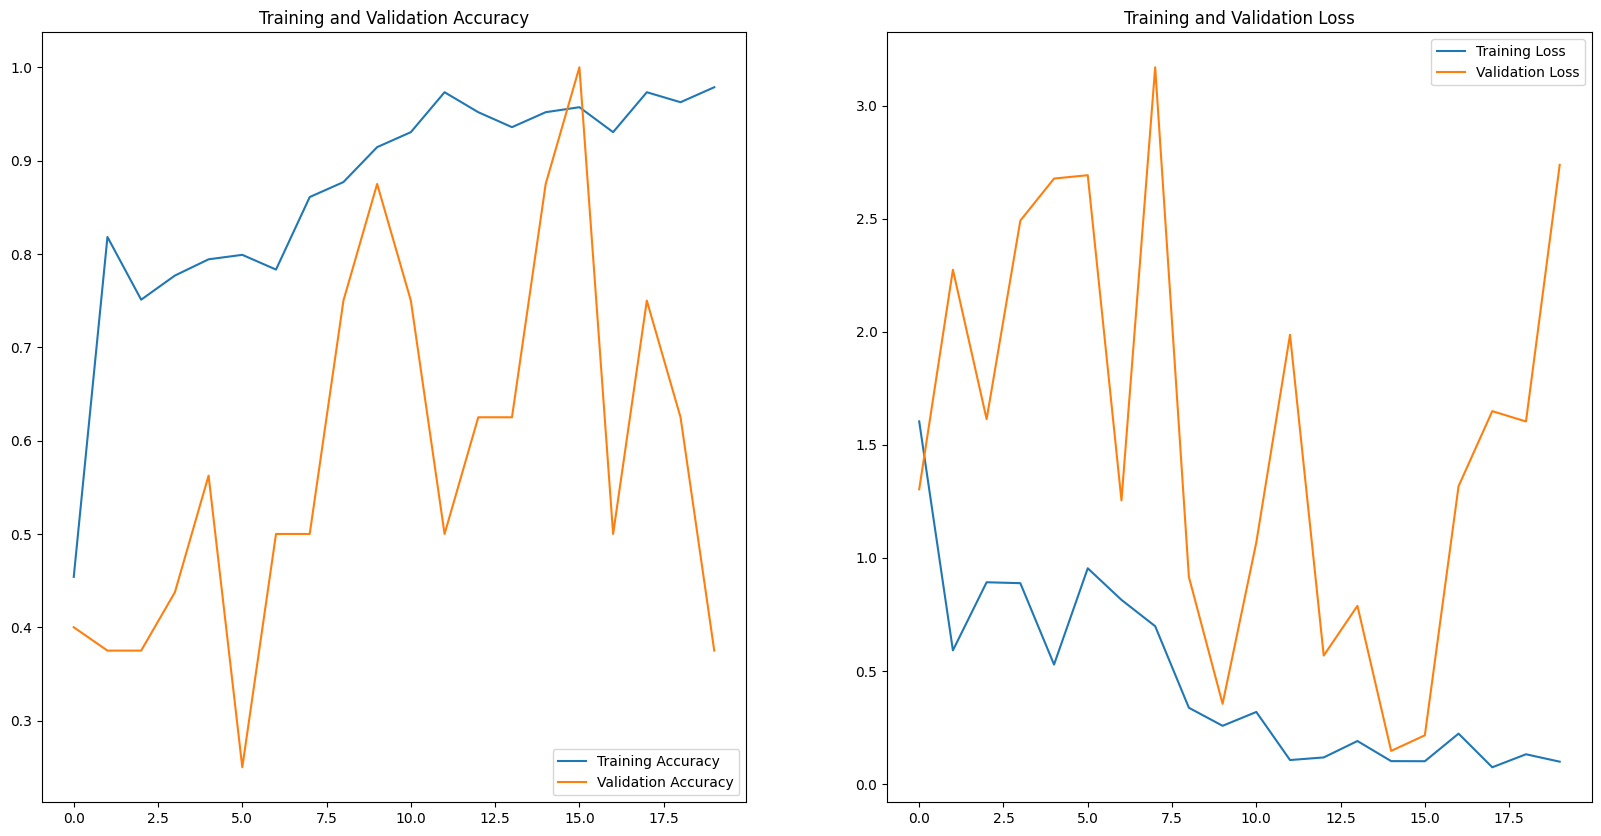

In [114]:
import matplotlib.pyplot as plt

plt.figure(figsize = (20, 15))

acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(20)

plt.figure(figsize=(20, 10))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [116]:
# Evaluate on Validation data
scores = model.evaluate(val_generator, verbose=1, steps=validation_steps*10, max_queue_size=3000, workers=1, use_multiprocessing=False)
print("%s%s: %.2f%%" % ("evaluate ",model.metrics_names[1], scores[1]*100))

20/20 [==============================] - 6s 291ms/step - loss: 1.7461 - categorical_accuracy: 0.6250
evaluate categorical_accuracy: 62.50%
